In [3]:
import numpy as np 
import tensorflow as tf 
from collections import Counter
import itertools

import utils.load_data as load_data
from speech_models.emotion_recognition import ClassifyEmotion

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt 
%matplotlib inline

In [1]:
%load_ext autoreload
%autoreload 2

# Load IEMOCAP Data 

The IEMOCAP data is saved into 5 sessions. Here scripted readings are mixed with improvised conversations. 

In [5]:
data, orig_lengths, labels, metadata = load_data.load_sentences(max_sequence_length=1000, 
                                                                win_len=.04, win_step=.02)

Finished data session Session1
Finished data session Session2
Finished data session Session3
Finished data session Session4
Finished data session Session5


In [39]:
cnt = Counter()
for emotion in labels:
    cnt[emotion] += 1
emotions = list(cnt.keys())
sizes = list(cnt.values())
cnt

Counter({'ang': 1103,
         'exc': 1041,
         'fru': 1849,
         'hap': 595,
         'neu': 1708,
         'sad': 1084})

([<matplotlib.patches.Wedge at 0x7fb805858e80>,
 [Text(-0.49772,0.980956,'ang'),
  Text(-1.0805,0.206211,'exc'),
  Text(-0.829873,-0.722018,'sad'),
  Text(-0.153554,-1.08923,'hap'),
  Text(0.819337,-0.733953,'neu'),
  Text(0.779141,0.776492,'fru')],
 [Text(-0.271484,0.535067,'14.9%'),
  Text(-0.589363,0.112479,'14.1%'),
  Text(-0.452658,-0.393828,'14.7%'),
  Text(-0.0837568,-0.594125,'8.1%'),
  Text(0.446911,-0.400338,'23.1%'),
  Text(0.424986,0.423541,'25.1%')])

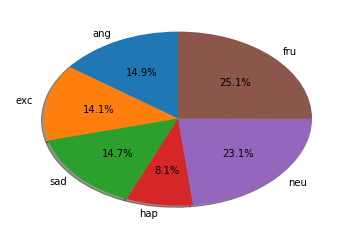

In [38]:
plt.pie(sizes, labels=emotions, shadow=True, startangle=90, autopct='%1.1f%%')

In [6]:
# Convert Y to one hot
int_labels = LabelEncoder().fit_transform(labels)
int_labels = int_labels.reshape(len(int_labels), 1)
onehot_labels = OneHotEncoder().fit_transform(int_labels).toarray()

In [10]:
# Subset limited amount of data for hyperparameter search 
lim_data = data[::10]
lim_lengths = orig_lengths[::10] 
lim_onehot_labels = onehot_labels[::10]

# Split into train and test
lim_train_x, lim_val_x, lim_train_y, lim_val_y, lim_train_lengths, lim_val_lengths = train_test_split(lim_data,
                                                                              lim_onehot_labels,
                                                                              lim_lengths,
                                                                              test_size=0.1)

# Hyperparameter search using limited data 

In [11]:
learning_rates = [.0001, .0005, .0007, .001]
truth = np.argmax(lim_val_y, 1) 

for lr in learning_rates:
    lstm = ClassifyEmotion(lr=lr, num_hidden=256)
    print(vars(lstm))
    val_pred = lstm.train(train_x=lim_train_x, val_x=lim_val_x, 
                          train_y=lim_train_y, val_y=lim_val_y, 
                          train_lengths=lim_train_lengths, 
                          val_lengths=lim_val_lengths, 
                          verbose=False, 
                          batch_size=32, epochs=50, load_model=False, 
                          save_path='final_model/lr_test.ckpt')
    acc = sum(val_pred == np.argmax(lim_val_y, 1))/len(val_pred)
    print('Accuracy: {}'.format(acc))

{'dense_hidden': 64, 'num_classes': 6, 'learning_rate': 0.0001, 'num_features': 26, 'num_hidden': 256}
Created 21 batches of size 32
Created Validation 3 batches of size 32
Data Batch Shape: (32, 1000, 26) Labels Shape: (32, 6) 
BLSTM-0 (?, 512)
BLSTM-1 (?, 512)
(?, 64)
(?, 6)
Epoch 0 mean batch val loss 1.7716026306152344
Epoch 5 mean batch val loss 1.672549843788147
Epoch 10 mean batch val loss 1.6704819202423096
Epoch 15 mean batch val loss 1.6707208156585693
Epoch 20 mean batch val loss 1.6707878112792969
Epoch 25 mean batch val loss 1.6708301305770874
Epoch 30 mean batch val loss 1.6708418130874634
Epoch 35 mean batch val loss 1.671813726425171
Epoch 40 mean batch val loss 1.6795858144760132
Epoch 45 mean batch val loss 1.6695420742034912
Epoch 49 mean batch val loss 1.6695420742034912
Accuracy: 0.20270270270270271
{'dense_hidden': 64, 'num_classes': 6, 'learning_rate': 0.0005, 'num_features': 26, 'num_hidden': 256}
Created 21 batches of size 32
Created Validation 3 batches of siz

KeyboardInterrupt: 

In [25]:
num_hidden = [512, 128, 64]

for h in num_hidden: 
    lstm = ClassifyEmotion(lr=.0005, num_hidden=h)
    print(vars(lstm))
    val_pred = lstm.train(train_x=lim_train_x, val_x=lim_val_x, 
                          train_y=lim_train_y, val_y=lim_val_y, 
                          train_lengths=lim_train_lengths, 
                          val_lengths=lim_val_lengths, 
                          verbose=False, 
                          batch_size=32, epochs=50, load_model=False, 
                          save_path='final_model/num_hidden_test.ckpt')
    acc = sum(val_pred == np.argmax(lim_val_y, 1))/len(val_pred)
    print('Accuracy: {}'.format(acc))

{'num_features': 26, 'num_classes': 6, 'learning_rate': 0.0005, 'num_hidden': 512}
Created 42 batches of size 32
Created Validation 5 batches of size 32
Data Batch Shape: (32, 750, 26) Labels Shape: (32, 6) 
(?, 1024)
(?, 1024)
(?, 256)
(?, 6)
Epoch 0 mean batch val loss 1.6801049709320068
Epoch 5 mean batch val loss 1.6791181564331055
Epoch 10 mean batch val loss 1.6758193969726562
Epoch 15 mean batch val loss 1.6723060607910156
Epoch 20 mean batch val loss 1.7721226215362549
Epoch 25 mean batch val loss 1.736720323562622
Epoch 30 mean batch val loss 1.733214020729065
Epoch 35 mean batch val loss 1.728166937828064
Epoch 40 mean batch val loss 1.7222931385040283
Epoch 45 mean batch val loss 1.715497612953186
Accuracy: 0.25
{'num_features': 26, 'num_classes': 6, 'learning_rate': 0.0005, 'num_hidden': 128}
Created 42 batches of size 32
Created Validation 5 batches of size 32
Data Batch Shape: (32, 750, 26) Labels Shape: (32, 6) 
(?, 256)
(?, 256)
(?, 64)
(?, 6)
Epoch 0 mean batch val los

In [27]:
# Dense layer hidden units = 512 
lstm = ClassifyEmotion(lr=.0005, num_hidden=64, dense_hidden=512)
print(vars(lstm))
val_pred = lstm.train(train_x=lim_train_x, val_x=lim_val_x, 
                      train_y=lim_train_y, val_y=lim_val_y, 
                      train_lengths=lim_train_lengths, 
                      val_lengths=lim_val_lengths, 
                      verbose=False, 
                      batch_size=32, epochs=50, load_model=False, 
                      save_path='final_model/num_hidden_test.ckpt')

{'num_features': 26, 'num_classes': 6, 'learning_rate': 0.0005, 'num_hidden': 64, 'dense_hidden': 512}
Created 42 batches of size 32
Created Validation 5 batches of size 32
Data Batch Shape: (32, 750, 26) Labels Shape: (32, 6) 
(?, 128)
(?, 128)
(?, 512)
(?, 6)
Epoch 0 mean batch val loss 1.6846727132797241
Epoch 5 mean batch val loss 1.6806259155273438
Epoch 10 mean batch val loss 1.6762855052947998
Epoch 15 mean batch val loss 1.6878869533538818
Epoch 20 mean batch val loss 1.6715717315673828
Epoch 25 mean batch val loss 1.666272521018982
Epoch 30 mean batch val loss 1.6656242609024048
Epoch 35 mean batch val loss 1.6539623737335205
Epoch 40 mean batch val loss 1.6508935689926147
Epoch 45 mean batch val loss 1.6635900735855103
Epoch 49 mean batch val loss 1.6635900735855103


In [28]:
acc = sum(val_pred == np.argmax(lim_val_y, 1))/len(val_pred)
print('Accuracy: {}'.format(acc))

Accuracy: 0.20270270270270271


# Train using all data 

In [12]:
# Split into train and test
train_x, val_x, train_y, val_y, train_lengths, val_lengths = train_test_split(data,
                                                                              onehot_labels,
                                                                              orig_lengths,
                                                                              test_size=0.2)

In [13]:
lstm = ClassifyEmotion(lr=.0002, num_hidden=128, dense_hidden=512)
print(vars(lstm))
val_predictions = lstm.train(train_x=train_x, val_x=val_x, train_y=train_y, val_y=val_y, 
                             train_lengths=train_lengths, val_lengths=val_lengths, 
                             batch_size=32, epochs=20, load_model=False, verbose=False,
                             save_path='final_model/emotion_recognition_1000.ckpt')

{'dense_hidden': 512, 'num_classes': 6, 'learning_rate': 0.0002, 'num_features': 26, 'num_hidden': 128}
Created 185 batches of size 32
Created Validation 47 batches of size 32
Data Batch Shape: (32, 1000, 26) Labels Shape: (32, 6) 
BLSTM-0 (?, 256)
BLSTM-1 (?, 256)
(?, 512)
(?, 6)
Epoch 0 mean batch val loss 1.5604650974273682
Epoch 5 mean batch val loss 1.5549639463424683
Epoch 10 mean batch val loss 1.5510139465332031
Epoch 15 mean batch val loss 1.5486640930175781
Epoch 19 mean batch val loss 1.5486640930175781


In [19]:
truth = np.argmax(val_y, 1)
correct = sum(val_predictions == truth)

correct/len(truth)

0.24661246612466126

# Train Using Even Class Sizes 

In [50]:
ang_idx = [i for i, x in enumerate(labels) if x=='ang'][:600]
fru_idx = [i for i, x in enumerate(labels) if x=='fru'][:600]
neu_idx = [i for i, x in enumerate(labels) if x=='neu'][:600]
exc_idx = [i for i, x in enumerate(labels) if x=='exc'][:600]
hap_idx = [i for i, x in enumerate(labels) if x=='hap']
sad_idx = [i for i, x in enumerate(labels) if x=='sad'][:600]

all_idx = ang_idx + fru_idx + neu_idx + exc_idx + hap_idx + sad_idx

balanced_data = data[all_idx, :]
balanced_labels = [label for i, label in enumerate(labels) if i in all_idx]
balanced_lengths = [l for i, l in enumerate(orig_lengths) if i in all_idx]

print(balanced_data.shape, len(balanced_labels), len(balanced_lengths))

# Convert Y to one hot
balanced_int_labels = LabelEncoder().fit_transform(balanced_labels)
balanced_int_labels = balanced_int_labels.reshape(len(balanced_int_labels), 1)
balanced_onehot_labels = OneHotEncoder().fit_transform(balanced_int_labels).toarray()

# Split into train and test
train_x, val_x, train_y, val_y, train_lengths, val_lengths = train_test_split(balanced_data,
                                                                              balanced_onehot_labels,
                                                                              balanced_lengths,
                                                                              test_size=0.1)

(3595, 1000, 26) 3595 3595


In [58]:
# Test to see if balanced dataset has decreasing error rates 
lstm = ClassifyEmotion(lr=.0005, num_hidden=128, dense_hidden=256)
print(vars(lstm))
val_pred_balanced = lstm.train(train_x=train_x, val_x=val_x, train_y=train_y, val_y=val_y, 
                             train_lengths=train_lengths, val_lengths=val_lengths, 
                             batch_size=16, epochs=5, load_model=False, verbose=True,
                             save_path='final_model/emotion_recognition_balanced.ckpt')

{'dense_hidden': 256, 'num_classes': 6, 'learning_rate': 0.0005, 'num_features': 26, 'num_hidden': 128}
Created 203 batches of size 16
Created Validation 23 batches of size 16
Data Batch Shape: (16, 1000, 26) Labels Shape: (16, 6) 
BLSTM-0 (?, 256)
BLSTM-1 (?, 256)
(?, 256)
(?, 6)
Epoch 0 mean loss 1.7924994230270386
Epoch 0 mean batch val loss 1.7941268682479858
Epoch 1 mean loss 1.7924065589904785
Epoch 1 mean batch val loss 1.7898458242416382
Epoch 2 mean loss 1.7921665906906128
Epoch 2 mean batch val loss 1.7896699905395508
Epoch 3 mean loss 1.7918757200241089
Epoch 3 mean batch val loss 1.7889657020568848
Epoch 4 mean loss 1.7912245988845825
Epoch 4 mean batch val loss 1.7889125347137451
Epoch 4 mean batch val loss 1.7889125347137451


In [ ]:
val_pred_truth = np.argmax(val_y, 1)
accuracy = sum(val_pred_truth == val_pred_balanced) / len(val_pred_truth)
accuracy